In [1]:
%load_ext autoreload

In [16]:
%autoreload 2

import os
import sys
import json
import pickle

from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr, correlation_contribution

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

from scipy.stats import kurtosis, skew

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sys.path.append("../")

from src.eda import plot_feature_dist

In [3]:
class cfg:
    dataset_path = "../dataset/v5.0"
    feature_set = "all"

In [4]:
with open(f"{cfg.dataset_path}/features.json", "r") as f:
    feature_metadata = json.load(f)

# print(feature_metadata.keys())
feature_sets = feature_metadata["feature_sets"]
# print(feature_sets.keys())
feature_set = feature_sets[cfg.feature_set]
print(f"feature col length: {len(feature_set)}") 

feature col length: 2376


In [17]:
for col in tqdm(feature_set):
    train = pd.read_parquet(
        f"{cfg.dataset_path}/train.parquet",
        columns=["era", "target"] + [col]
    )

    # print(train[col].value_counts())
    is_five = set(train[col].unique()) == set([0, 1, 2, 3, 4])
    if not is_five:
        print(col)
        print(train[col].unique())
    # print("=" * 64) 
    # break


  0%|          | 0/2376 [00:00<?, ?it/s]

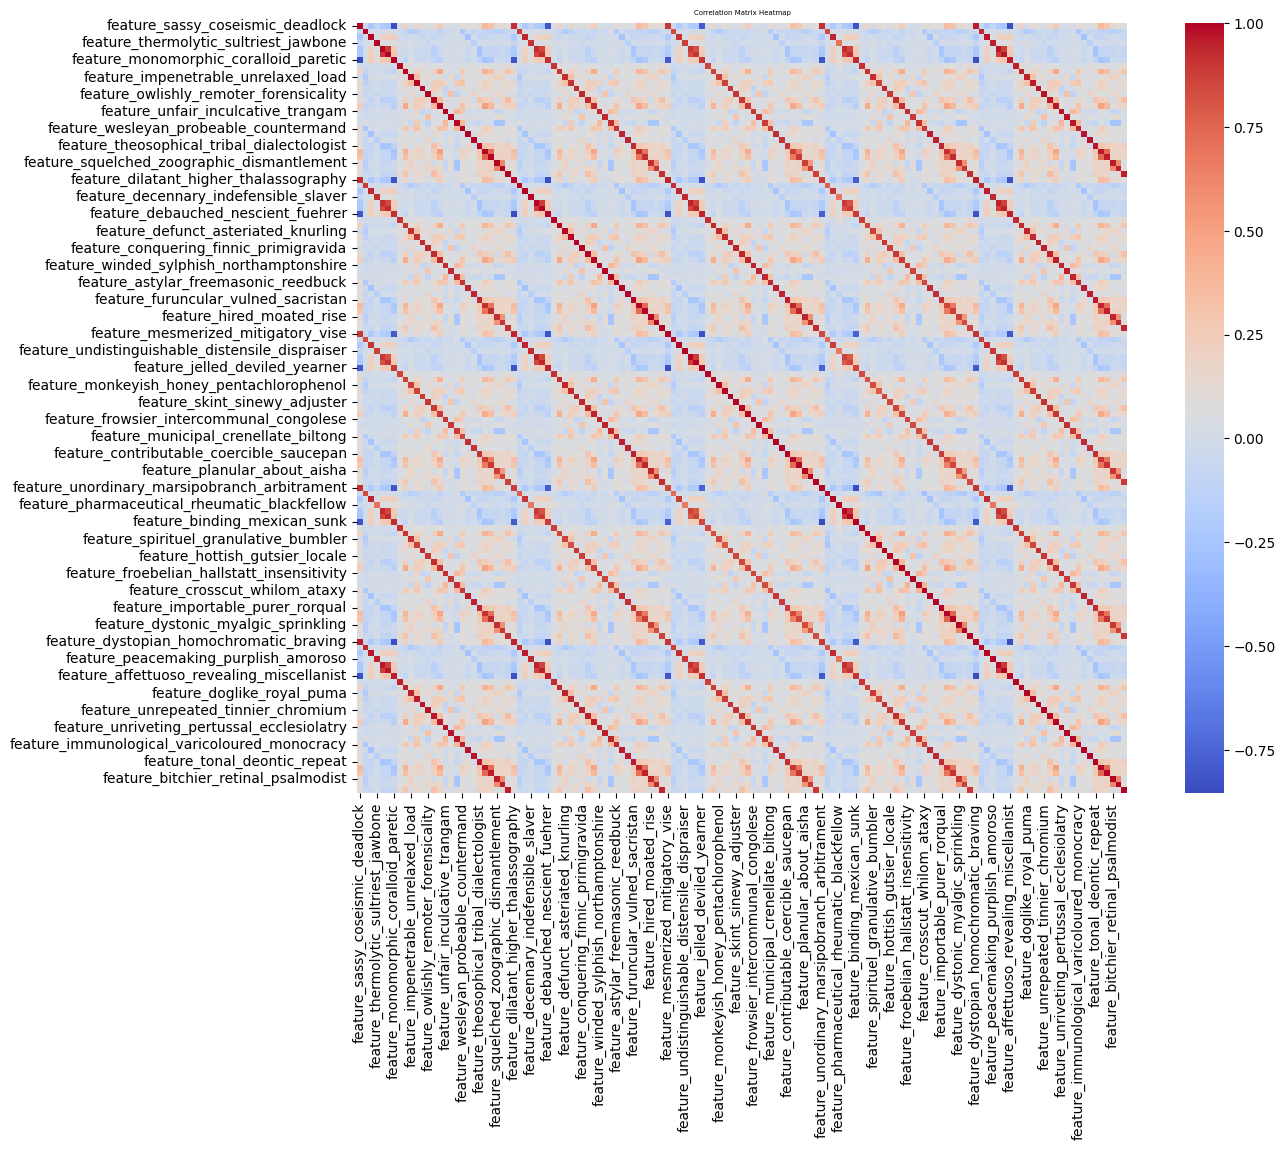

除外する特徴量: ['feature_confusable_liquorish_western', 'feature_aggregate_biliteral_enceinte', 'feature_anionic_glottidean_heath', 'feature_peacemaking_purplish_amoroso', 'feature_ulcerative_inductive_giza', 'feature_unrepeated_tinnier_chromium', 'feature_salt_menshevist_abaca', 'feature_saprozoic_dolce_dactylic', 'feature_dystopian_homochromatic_braving', 'feature_overstrong_burrier_guevara', 'feature_shabbiest_offending_havel', 'feature_contributable_coercible_saucepan', 'feature_hurling_elastomeric_nanny', 'feature_doglike_royal_puma', 'feature_bitchier_retinal_psalmodist', 'feature_prowessed_expedient_cardiology', 'feature_braided_neighbourly_fairyhood', 'feature_terrorist_shamefaced_labrid', 'feature_unvital_indecomposable_feedlot', 'feature_immunological_varicoloured_monocracy', 'feature_ailurophobic_boggy_trocar', 'feature_silenced_tagged_hexapla', 'feature_tonal_deontic_repeat', 'feature_bunchier_plical_kilojoule', 'feature_wheezy_irritant_discard', 'feature_unriveting_pertussal_ecc

In [18]:
features = [col for col in train.columns if "feature" in col]

correlation_matrix = train[features].corr()
# ヒートマップの作成
plt.figure(figsize=(15, 10))
sns.heatmap(
    correlation_matrix,
    # annot=True,  # 相関係数をセルに表示
    fmt=".2f",  # 小数点以下2桁でフォーマット
    cmap="coolwarm",  # カラーマップ
    cbar=True,  # カラーバーを表示
    square=True,  # セルを正方形に
)
plt.title("Correlation Matrix Heatmap", fontsize=5)
plt.show()

# 高相関のペアを特定（絶対値が0.9以上）
threshold = 0.95

high_corr_pairs = [
    (col1, col2)
    for col1 in correlation_matrix.columns
    for col2 in correlation_matrix.columns
    if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > threshold
]

# print("高相関のペア:", high_corr_pairs)

# 高相関な特徴量を除外する
# 上三角行列を取得して、片方の列のみ除外する
def remove_high_corr_features(corr_matrix, threshold):
    to_drop = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                to_drop.add(corr_matrix.columns[i])
    return list(to_drop)

# 除外する特徴量を特定
features_to_drop = remove_high_corr_features(correlation_matrix, threshold)
print("除外する特徴量:", features_to_drop)

# データフレームから高相関な特徴量を除外
train_filtered = train.drop(columns=features_to_drop)


print("フィルタリング前")
print(train.shape)
print("フィルタリング後のデータ:")
print(train_filtered.shape)